In [1]:
import os
import json
import tweepy
import networkx
import matplotlib.pyplot as plt
from pylab import rcParams
from datetime import datetime, timedelta
from pyvis.network import Network
import pandas as pd

In [2]:
bearer_token = "bearer_token"

In [3]:
# cartelle
data_folder = "data"
graphs_folder = "graphs"
pyvis_folder = "html"
view_folder = "view"
stats_folder = "stats"

# pallette
c_bianco = "#ffffff"
c_nero = "#000000"
c_primario = "#6B9EE1" # blu
c_secondario = "#86F5FA" # azzurro
c_terziario = "#ebebeb" # grigio chiaro
c_rosso ="#CB3234"
c_alpha ="3f"

# Salvataggio dati in locale
def serialize_json(folder, filename, data):
    # Se la cartella non esiste la creo
    if not os.path.exists(folder):
        os.makedirs(folder, exist_ok=True)
    with open(f"{folder}/{filename}", 'w', encoding='utf-8') as f:
        json.dump(data, f, ensure_ascii=False, indent=4)
        f.close()
    print(f"Data serialized to path: {folder}/{filename}")

# Lettura file JSON da locale
def read_json(path):
    if os.path.exists(path):
        with open(path, "r", encoding="utf8") as file:
            data = json.load(file, object_hook = lambda d: {int(k) if k.lstrip('-').isdigit() else k: v for k, v in d.items()}) # object_hook per convertire le stringhe numeriche in numeri (es. id del follower)
        print(f"Data read from path: {path}")
        return data
    else:
        print(f"No data found at path: {path}")
        return {}

# Visualizzazione grafico
def draw(G, pos, node_color, edge_color, labels, with_labels, node_size, title, path_save):
    rcParams['figure.figsize'] = 10, 10
    nodes = networkx.draw_networkx_nodes(G, pos=pos, node_color=node_color, node_size=node_size, edgecolors=c_nero)
    if(with_labels):
        labels = networkx.draw_networkx_labels(G, pos, labels=labels)
    edges = networkx.draw_networkx_edges(G, pos, edge_color=edge_color, width=1)
    plt.title(title)
    plt.axis('off')
    plt.savefig(path_save)
    plt.show()

# Visualizzazione grafico in base alla misura
def draw_measure(G, pos, with_labels, measures, title, path_save):
    rcParams['figure.figsize'] = 10, 10
    nodes = networkx.draw_networkx_nodes(G, pos, cmap=plt.cm.winter, nodelist=measures.keys(), node_color=list(measures.values()), node_size=150, edgecolors=c_nero)
    if(with_labels):
        labels = networkx.draw_networkx_labels(G, pos, labels=measures.keys())
    edges = networkx.draw_networkx_edges(G, pos, edge_color=f"{c_nero}{c_alpha}", width=1)
    plt.title(title)
    plt.colorbar(nodes)
    plt.axis('off')
    plt.savefig(path_save)
    plt.show()


# 1.Usando Tweepy scaricate tutti i follower del profilo Twitter con username @KevinRoitero (ad oggi 131 Follower). Per ciascuno di questi follower scaricare:
1. Attributi di default
2. Descrizione del profilo
3. Metriche pubbliche dell’account (followers_count, following_count, tweet_count, listed_count)
4. Se l’account è protetto (protected)
5. Salvare una unica serializzazione JSON dei risultati recuperati

In [4]:
# Cerco anche i dati di KevinRoitero per poterlo inserire sucessivamnete nel grafo

client = tweepy.Client(bearer_token = bearer_token, wait_on_rate_limit=True) # wait_on_rate_limit attende quando sforo i limiti dell'endpoint

user = "KevinRoitero"

response = client.get_user(username=user, user_fields = ["description", "public_metrics", "protected"])

kevinroitero = {
    "id": response.data["id"], 
    "name": response.data["name"], 
    "username": response.data["username"],
    "description": response.data["description"],
    "public_metrics": response.data["public_metrics"],
    "protected": response.data["protected"],
    "followers": {}
}

# Cerco i suoi followers

user_followers = {}
for user_current_follower in tweepy.Paginator(client.get_users_followers, id = kevinroitero["id"], user_fields = ["description", "public_metrics", "protected"]):
    for follower in user_current_follower.data:
        found_follower = {
            "name": follower["name"], 
            "username": follower["username"],
            "description": follower["description"],
            "public_metrics": follower["public_metrics"],
            "protected": follower["protected"],
            "followers": {}
        }
        user_followers[follower["id"]] = found_follower
print(f"Trovati {len(user_followers)} followers per {kevinroitero['username']}")

kevinroitero["followers"] = user_followers

serialize_json(data_folder, "kevinroitero.json", kevinroitero)


Trovati 133 followers per KevinRoitero
Data serialized to path: data/kevinroitero.json


# 2.Per ciascun follower del profilo @KevinRoitero utilizzare Tweepy per scaricare il numero di tweet pubblicati da quel profilo durante l’ultima settimana ed aggiungere tale informazione al JSON prodotto al punto 1

In [5]:
# Cerco il numero di tweet dell'ultima settimana dei suoi followers

start_time = datetime.today() - timedelta(days = 7)

for id, follower in kevinroitero["followers"].items():
    response = client.get_users_tweets(id = id, start_time = start_time)
    if response.data == None:
        last_week_tweet_count = 0
    else:
        last_week_tweet_count = len(response.data)
    follower["last_week_tweet_count"] = last_week_tweet_count

serialize_json(data_folder, "kevinroitero.json", kevinroitero)


Data serialized to path: data/kevinroitero.json


# 3.Per ciascuno dei follower di @KevinRoitero che hanno almeno un follower e che non sono account protected scaricare 1000 follower salvando per ciascuno di essi le stesse informazioni dettagliate al punto 1: descrizione del profilo, metriche pubbliche dell’account e se l’account è protetto. (Se un profilo ha meno di 1000 follower, scaricarli tutti; se ne ha di più, limitarsi a 1000). Serializzare in locale il JSON risultante, che avrà una struttura simile al seguente esempio:
    {
        id : {
            'name': 'Nome Cognome',
            'username': 'username',
            'description': 'Descrizione del profilo',
            'public_metrics': {
                'followers_count': 0,
                'following_count': 0,
                'tweet_count': 0,
                'listed_count': 0
            },
            'protected': Bool,
            'last_week_tweets_count': 0,
            followers = [{...}]
        },
        id : {...},
        ...
    }

In [6]:
# Cerco i followers dei suoi followers

for id, follower in kevinroitero["followers"].items():
    if not follower["protected"] and follower["public_metrics"]["followers_count"] > 0:
        user_followers = {}
        for user_current_follower in tweepy.Paginator(client.get_users_followers, id = id, user_fields = ["description", "public_metrics", "protected"], max_results = 100, limit = 10): # massimo 10 richieste e 100 risultati per richiesta (1000 risultati)
            for follower_follower in user_current_follower.data:
                found_follower = {
                    "name": follower_follower["name"], 
                    "username": follower_follower["username"],
                    "description": follower_follower["description"],
                    "public_metrics": follower_follower["public_metrics"],
                    "protected": follower_follower["protected"]
                }
                user_followers[follower_follower["id"]] = found_follower
        print(f"Trovati {len(user_followers)} followers per {follower['username']}")
        follower["followers"] = user_followers

serialize_json(data_folder, "kevinroitero.json", kevinroitero)


Rate limit exceeded. Sleeping for 755 seconds.


Trovati 108 followers per clacostacc
Trovati 3 followers per Matteo34521130
Trovati 145 followers per OlegZendel
Trovati 62 followers per SalarMohtaj
Trovati 303 followers per _ElisaC_
Trovati 64 followers per dominsta_nlp


Rate limit exceeded. Sleeping for 897 seconds.


Trovati 460 followers per davideceolin
Trovati 120 followers per joelmmackenzie
Trovati 18 followers per labarbera_dav
Trovati 295 followers per oana_inel
Trovati 15 followers per BHCC2022
Trovati 420 followers per Il_Bale_


Rate limit exceeded. Sleeping for 897 seconds.


Trovati 385 followers per danulaera
Trovati 262 followers per hscells
Trovati 104 followers per alisarieg
Trovati 162 followers per tahir_80
Trovati 455 followers per _nirmalroy


Rate limit exceeded. Sleeping for 897 seconds.


Trovati 235 followers per timdr4ws
Trovati 1000 followers per tetsuyasakai


Rate limit exceeded. Sleeping for 897 seconds.


Trovati 202 followers per MengdieChmod777
Trovati 183 followers per ahsmourad
Trovati 67 followers per 2021Iir
Trovati 1000 followers per mcinerneyj


Rate limit exceeded. Sleeping for 897 seconds.


Trovati 839 followers per CIKM2021
Trovati 576 followers per giansilv
Trovati 62 followers per SachinPC10


Rate limit exceeded. Sleeping for 897 seconds.


Trovati 498 followers per Adienge3
Trovati 265 followers per alerubicini
Trovati 89 followers per EddyMaddalena
Trovati 259 followers per rmit_cidda


Rate limit exceeded. Sleeping for 897 seconds.


Trovati 1000 followers per flosalim
Trovati 141 followers per rodger_benham


Rate limit exceeded. Sleeping for 897 seconds.


Trovati 787 followers per shoegazerstella
Trovati 1000 followers per ttwwecon
Trovati 37 followers per manishb89


Rate limit exceeded. Sleeping for 897 seconds.


Trovati 1000 followers per AryaArshia


Rate limit exceeded. Sleeping for 897 seconds.


Trovati 1000 followers per arvidmartin
Trovati 887 followers per cikm2020
Trovati 199 followers per Lombardo_GG


Rate limit exceeded. Sleeping for 897 seconds.


Trovati 1000 followers per WWRob
Trovati 83 followers per huml_
Trovati 2 followers per dvdvgl
Trovati 177 followers per jayzhang_syd
Trovati 186 followers per vidiemme


Rate limit exceeded. Sleeping for 897 seconds.


Trovati 999 followers per pascalguyon


Rate limit exceeded. Sleeping for 897 seconds.


Trovati 669 followers per JTrippas
Trovati 983 followers per antonio_mallia


Rate limit exceeded. Sleeping for 897 seconds.


Trovati 1000 followers per HLForum
Trovati 788 followers per pchandarr


Rate limit exceeded. Sleeping for 897 seconds.


Trovati 1000 followers per JulioGonzalo1


Rate limit exceeded. Sleeping for 897 seconds.


Trovati 1000 followers per julian_urbano
Trovati 521 followers per HCjnl


Rate limit exceeded. Sleeping for 897 seconds.


Trovati 999 followers per amrapaliz


Rate limit exceeded. Sleeping for 897 seconds.


Trovati 1000 followers per BenCarterette
Trovati 247 followers per Perangur
Trovati 124 followers per hiijjournal1


Rate limit exceeded. Sleeping for 896 seconds.


Trovati 1000 followers per arjenpdevries
Trovati 1000 followers per UjLaw
Trovati 233 followers per DGarigliotti
Trovati 81 followers per lgr3d


Rate limit exceeded. Sleeping for 896 seconds.


Trovati 38 followers per LinTing_SG
Trovati 621 followers per SpringerIRJ
Trovati 74 followers per alex_checco


Rate limit exceeded. Sleeping for 897 seconds.


Trovati 1000 followers per mounialalmas
Trovati 246 followers per BrazierPhD
Trovati 316 followers per zuacsea


Rate limit exceeded. Sleeping for 897 seconds.


Trovati 1000 followers per damiano10
Trovati 408 followers per sculpepper


Rate limit exceeded. Sleeping for 897 seconds.


Trovati 958 followers per shashank27392
Trovati 898 followers per ESSAYWRITERD


Rate limit exceeded. Sleeping for 897 seconds.


Trovati 66 followers per medardAttoukou
Trovati 560 followers per t0zecorreia
Trovati 131 followers per amrahoff
Trovati 415 followers per raffaele_perego


Rate limit exceeded. Sleeping for 896 seconds.


Trovati 137 followers per ABH878
Trovati 549 followers per fmnardini
Trovati 200 followers per ida_mele
Trovati 103 followers per tranisalvatore
Trovati 201 followers per CriMuntean


Rate limit exceeded. Sleeping for 897 seconds.


Trovati 200 followers per essir2017
Trovati 405 followers per b_kandemirci
Trovati 177 followers per mizzaro
Trovati 9 followers per LucaStefanuto1


Rate limit exceeded. Sleeping for 897 seconds.


Trovati 1000 followers per maliannejadi
Trovati 106 followers per ntcirwww
Trovati 524 followers per cs2_school
Trovati 233 followers per www17perth


Rate limit exceeded. Sleeping for 897 seconds.


Trovati 1000 followers per ACMSIGIR


Rate limit exceeded. Sleeping for 896 seconds.


Trovati 927 followers per SIGIR17
Trovati 11 followers per Gloria38099293
Trovati 337 followers per Miccighel_
Trovati 66 followers per Andreacarri26


Rate limit exceeded. Sleeping for 897 seconds.


Trovati 1000 followers per ScienceofStuff
Trovati 255 followers per sap_shareaplace


Rate limit exceeded. Sleeping for 896 seconds.


Trovati 1000 followers per lodgeoapp
Trovati 32 followers per aleksey98st
Trovati 287 followers per Giorgiattone


Rate limit exceeded. Sleeping for 896 seconds.


Trovati 844 followers per emma_ryder_
Trovati 3 followers per ZanchettaSara
Trovati 1000 followers per tweet_italia


Rate limit exceeded. Sleeping for 896 seconds.


Trovati 453 followers per jjohnddoe
Trovati 1000 followers per _Courteney_Cox_


Rate limit exceeded. Sleeping for 896 seconds.


Trovati 326 followers per ADSLab_ads
Trovati 175 followers per realtornomore
Trovati 522 followers per travelto_to
Trovati 6 followers per __cutodaym69
Trovati 31 followers per cansjzm


Rate limit exceeded. Sleeping for 897 seconds.


Trovati 555 followers per Realistic667
Trovati 1000 followers per Hope_4_humanity
Trovati 24 followers per LucaPighin92
Trovati 72 followers per CallFashion11


Rate limit exceeded. Sleeping for 896 seconds.


Trovati 277 followers per girlsonlyknow1
Trovati 328 followers per StefaniaMartin_
Trovati 178 followers per LaPausaInfo
Trovati 268 followers per Dandy_Shore


Rate limit exceeded. Sleeping for 896 seconds.


Trovati 999 followers per BozFrancesco


Rate limit exceeded. Sleeping for 896 seconds.


Trovati 1000 followers per MaiaraWalsh
Trovati 218 followers per speaktherumors
Trovati 449 followers per Nozioni_a_caso


Rate limit exceeded. Sleeping for 897 seconds.


Trovati 1000 followers per CreepySound
Trovati 1000 followers per InsultiForbiti


Rate limit exceeded. Sleeping for 897 seconds.


Trovati 104 followers per magneet088a684
Trovati 1000 followers per Mariellex
Trovati 117 followers per pavandrea


Rate limit exceeded. Sleeping for 897 seconds.


Trovati 1000 followers per MastroRetweet
Trovati 66 followers per martysantarossa
Trovati 219 followers per ddloovato_8
Data serialized to path: data/kevinroitero.json


In [7]:
# Leggo il file

kevinroitero = read_json(f"{data_folder}/kevinroitero.json")


Data read from path: data/kevinroitero.json


# 4.Utilizzando NetworkX costruire la rete sociale diretta (grafo diretto) dove:
1. I nodi sono KevinRoitero ed i suoi follower con id del nodo uguale all’id del profilo utente e ciascun nodo ha come attributi username, la descrizione, ed il numero di follower di quel profilo.
2. Utilizzando il JSON prodotto al punto 3 aggiungere al grafo un arco per ogni coppia di profili per cui esiste una relazione di following tra i due profili nei dati recuperati al punto 3.

Es. Siano A e B due profili follower di @KevinRoitero appartenenti al grafo. Aggiungo un arco (A, B) al grafo se e solo se nel JSON prodotto al punto 3 trovo che A è follower di B.

NOTA: In questo modo il grafo prodotto sarà subottimale e non conterrà tutte le relazioni di follow tra i follower di @KevinRoitero. Inoltre, gruppi diversi potrebbero ottenere grafi con archi diversi, a seconda dei 1000 profili scaricati per ogni follower al punto 3.

In [8]:
# Costruisco il grafo diretto

# Inserisco i nodi (KevinRoitero e i suoi followers)

kevinroitero_direct_graph = networkx.DiGraph()

kevinroitero_direct_graph.add_node(kevinroitero["id"], username = kevinroitero["username"], description = kevinroitero["description"], followers_count = kevinroitero["public_metrics"]["followers_count"])

for id, follower in kevinroitero["followers"].items():
    kevinroitero_direct_graph.add_node(id, username = follower["username"], description = follower["description"], followers_count = follower["public_metrics"]["followers_count"])

# Aggiungo gli archi tra KevinRoitero e i suoi followers

for id, follower in kevinroitero["followers"].items():
    kevinroitero_direct_graph.add_edge(id, kevinroitero["id"])

# Aggiungo gli archi tra i suoi followers (utilizzando i follower dei suoi follower)

for id, follower in kevinroitero["followers"].items():
    for follower_id, follower_follower in follower["followers"].items():
        if(kevinroitero["followers"].get(follower_id, None) != None):
            kevinroitero_direct_graph.add_edge(follower_id, id)

# Salvo in json

kevinroitero_direct_graph_json = networkx.node_link_data(kevinroitero_direct_graph)
serialize_json(graphs_folder, "kevinroitero_direct_graph.json", kevinroitero_direct_graph_json)

# Salvo anche in gpickle (extra)

networkx.write_gpickle(kevinroitero_direct_graph, f"{graphs_folder}/kevinroitero_direct_graph.pkl")


Data serialized to path: graphs/kevinroitero_direct_graph.json


In [9]:
# Leggo il file json

kevinroitero_direct_graph_json = read_json(f"{graphs_folder}/kevinroitero_direct_graph.json")
kevinroitero_direct_graph = networkx.node_link_graph(kevinroitero_direct_graph_json)

# Leggo il file gpickle (extra)

#kevinroitero_direct_graph = networkx.read_gpickle(f"{graphs_folder}/kevinroitero_direct_graph.pkl")


Data read from path: graphs/kevinroitero_direct_graph.json


# 5.Generare un secondo grafo, nel modo seguente. Utilizzando la funzione apposita di NetworkX, trasformare il grafo prodotto al punto 3 in indiretto. Utilizzare poi il metodo del preferential attachment per aggiungere nodi e archi a questo grafo indiretto, fino ad ottenere un grafo con il doppio dei nodi rispetto al grafo di partenza. Ciascuno dei nuovi nodi dovrà avere 2 archi uscenti.

In [10]:
# Trasformo il grafo in indiretto

kevinroitero_indirect_graph = kevinroitero_direct_graph.to_undirected()

# Aggiungo altri n nodi tramite preferential attachment
kevinroitero_indirect_graph_preferential_attachment = networkx.barabasi_albert_graph(kevinroitero_indirect_graph.number_of_nodes()*2, 2, initial_graph = kevinroitero_indirect_graph)

# Salvo in json

kevinroitero_indirect_graph_preferential_attachment_json = networkx.node_link_data(kevinroitero_indirect_graph_preferential_attachment)
serialize_json(graphs_folder, "kevinroitero_indirect_graph.json", kevinroitero_indirect_graph_preferential_attachment_json)

# Salvo anche in gpickle (extra)

networkx.write_gpickle(kevinroitero_indirect_graph_preferential_attachment, f"{graphs_folder}/kevinroitero_indirect_graph.pkl")


Data serialized to path: graphs/kevinroitero_indirect_graph.json


In [11]:
# Leggo il file

kevinroitero_indirect_graph_preferential_attachment_json = read_json(f"{graphs_folder}/kevinroitero_indirect_graph.json")
kevinroitero_indirect_graph_preferential_attachment = networkx.node_link_graph(kevinroitero_indirect_graph_preferential_attachment_json)

# Leggo il file gpickle (extra)

#kevinroitero_indirect_graph_preferential_attachment = networkx.read_gpickle(f"{graphs_folder}/kevinroitero_indirect_graph.pkl")


Data read from path: graphs/kevinroitero_indirect_graph.json


# 6.Produrre due visualizzazioni per ciascuno dei due grafi prodotti ai punti 3 e 5:
1. Una interattiva utilizzando PyVis
2. Una statica utilizzando NetworkX e il layout di Fruchterman Reingold in cui:
    1. Per la versione diretta del grafo la dimensione dei nodi dipende dal grado in ingresso del nodo
    2. Per la versione indiretta del grafo la dimensione dipende dal grado del nodo

In [12]:
!mkdir html
%cd html

mkdir: html: File exists
/Users/gianluca/Desktop/progetti_sc/Progetto 1/html


In [13]:
# Visualizzazione grafo diretto PyVis

nt = Network(height="100%", width="100%", bgcolor=c_bianco, font_color=c_nero, heading="Kevin Roitero direct graph", directed=True)
nt.barnes_hut()
nt.from_nx(kevinroitero_direct_graph)

neighbor_map = nt.get_adj_list()

# Creo i colori e labels dei nodi
for node in nt.nodes:
    node["value"] = len(neighbor_map[node["id"]])
    node["label"] = node["username"] # rinomino le label (da id a username) per migliorare la visualizzazione
    node["title"] = node['username']
    if(node["username"] == "KevinRoitero"):
        node["color"] = c_secondario
    else:
        node["color"] = c_primario

# Creo i colori degli archi
for edge in nt.edges:
    if(edge["to"] == 3036907250): # 3036907250 = KevinRoitero
        edge["color"] = f"{c_secondario}{c_alpha}"
    else:
        edge["color"] = f"{c_primario}{c_alpha}"

nt.show("kevinroitero_direct_graph.html")

# Visualizzazione grafo indiretto PyVis

nt = Network(height="100%", width="100%", bgcolor=c_bianco, font_color=c_nero, heading="Kevin Roitero indirect graph", directed=False)
nt.barnes_hut()
nt.from_nx(kevinroitero_indirect_graph_preferential_attachment)

neighbor_map = nt.get_adj_list()

# Creo i colori e labels dei nodi
for node in nt.nodes:
    node["value"] = len(neighbor_map[node["id"]])
    if(node["id"] in range(len(kevinroitero_direct_graph.nodes), len(kevinroitero_direct_graph.nodes)*2)):
        node["username"] = f"attacamento preferenziale {node['id']-len(kevinroitero_direct_graph.nodes)+1}" # inserieco username (fittizio) per i nodi con attacamento preferenziale
    node["label"] = node["username"] # rinomino le label (da id a username) per migliorare la visualizzazione
    node["title"] = node['username']
    if(node["username"] == "KevinRoitero"):
        node["color"] = c_secondario
    elif(node["id"] in range(len(kevinroitero_direct_graph.nodes), len(kevinroitero_direct_graph.nodes)*2)):
        node["color"] = c_terziario
    else:
        node["color"] = c_primario

# Creo i colori degli archi
for edge in nt.edges:
    if(edge["to"] == 3036907250 or edge["from"] == 3036907250): # 3036907250 = KevinRoitero
        edge["color"] = f"{c_secondario}{c_alpha}"
    elif(edge["from"] in range(len(kevinroitero_direct_graph.nodes), len(kevinroitero_direct_graph.nodes)*2) or edge["to"] in range(len(kevinroitero_direct_graph.nodes), len(kevinroitero_direct_graph.nodes)*2)):
        edge["color"] = f"{c_terziario}{c_alpha}"
    else:
        edge["color"] = f"{c_primario}{c_alpha}"

nt.show("kevinroitero_indirect_graph.html")


In [14]:
%cd ../

/Users/gianluca/Desktop/progetti_sc/Progetto 1


In [15]:
!mkdir view

mkdir: view: File exists


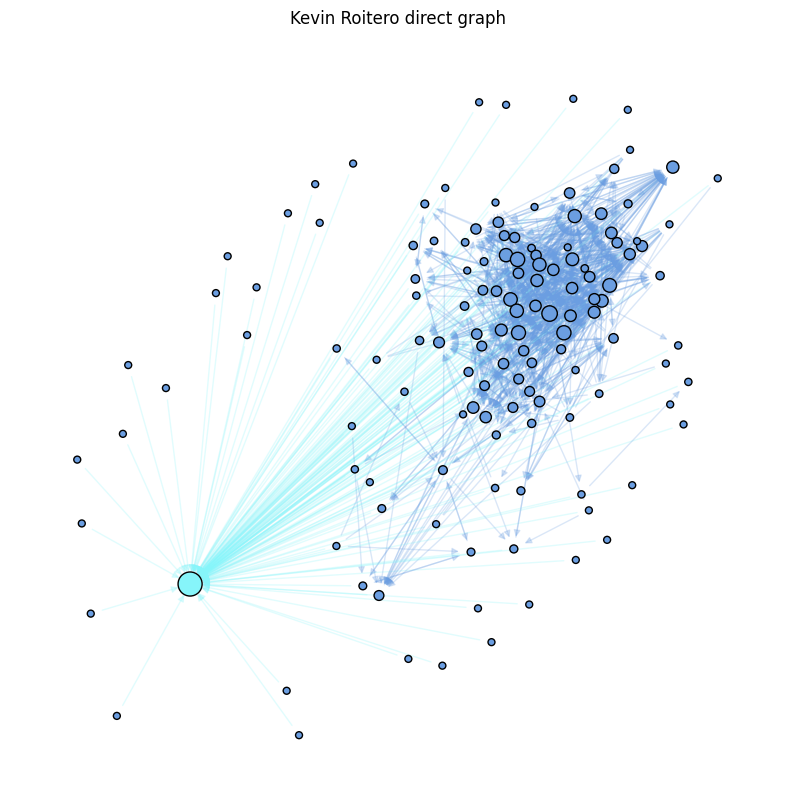

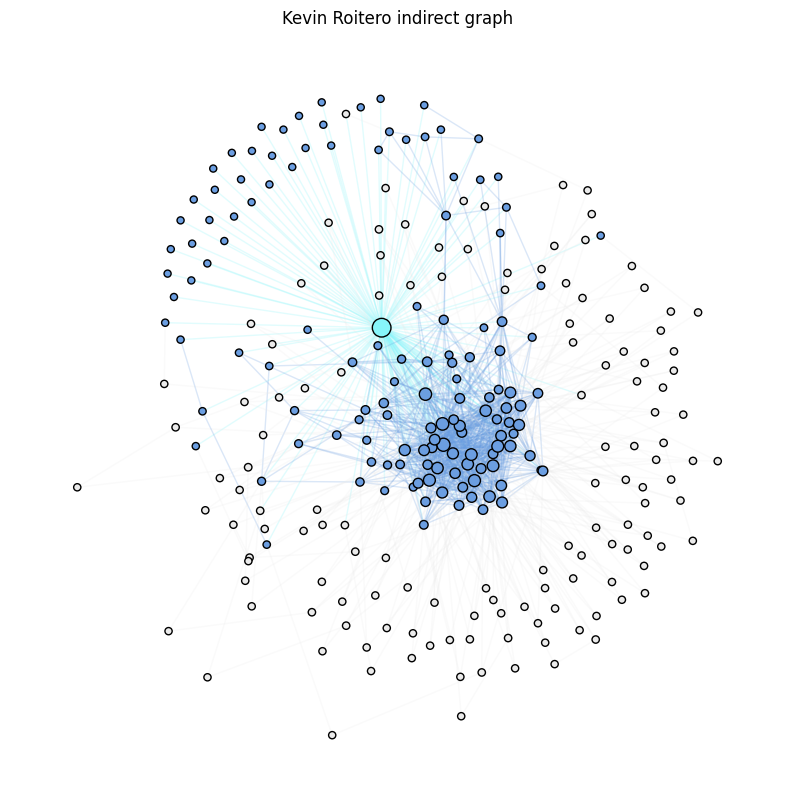

In [16]:
# Visualizzazione grafo diretto Fruchterman Reingold

# Creo i colori, labels e dimensione dei nodi
c_nodes = []
labels = {}
node_size = []
kevinroitero_direct_graph_in_degree = networkx.in_degree_centrality(kevinroitero_direct_graph)
for id, node in kevinroitero_direct_graph.nodes(data=True):
    if(id == 3036907250):
        c_nodes.append(c_secondario)
    else:
        c_nodes.append(c_primario)
    labels[id] = node["username"]
    node_size.append(kevinroitero_direct_graph_in_degree[id]*275+25) # punto A

# Creo i colori degli archi
c_edges = []
for edge in kevinroitero_direct_graph.edges:
    if(edge[1] == 3036907250): # edge[1] = edge["to"]
        c_edges.append(f"{c_secondario}{c_alpha}")
    else:
        c_edges.append(f"{c_primario}{c_alpha}")

draw(kevinroitero_direct_graph, networkx.spring_layout(kevinroitero_direct_graph), c_nodes, c_edges, labels, False, node_size, "Kevin Roitero direct graph", f"{view_folder}/kevinroitero_direct_graph.png")

# Visualizzazione grafo indiretto Fruchterman Reingold

# Creo i colori, labels e dimensione dei nodi
c_nodes = []
labels = {}
node_size = []
kevinroitero_indirect_graph_preferential_attachment_degree = networkx.degree_centrality(kevinroitero_indirect_graph_preferential_attachment)
for id, node in kevinroitero_indirect_graph_preferential_attachment.nodes(data=True):
    if(id == 3036907250):
        c_nodes.append(c_secondario)
    elif(id in range(len(kevinroitero_direct_graph.nodes), len(kevinroitero_direct_graph.nodes)*2)):
        c_nodes.append(c_terziario)
        node["username"] = f"attacamento preferenziale {id-len(kevinroitero_direct_graph.nodes)+1}"
    else:
        c_nodes.append(c_primario)
    labels[id] = node["username"]
    node_size.append(kevinroitero_indirect_graph_preferential_attachment_degree[id]*275+25) # punto B

# Creo i colori degli archi
c_edges = []
for edge in kevinroitero_indirect_graph_preferential_attachment.edges:
    if(edge[1] == 3036907250 or edge[0] == 3036907250): # edge[1] = edge["to"], edge[0] = edge["from"]
        c_edges.append(f"{c_secondario}{c_alpha}")
    elif(edge[1] in range(len(kevinroitero_direct_graph.nodes), len(kevinroitero_direct_graph.nodes)*2) or edge[0] in range(len(kevinroitero_direct_graph.nodes), len(kevinroitero_direct_graph.nodes)*2)):
        c_edges.append(f"{c_terziario}{c_alpha}")
    else:
        c_edges.append(f"{c_primario}{c_alpha}")

draw(kevinroitero_indirect_graph_preferential_attachment, networkx.spring_layout(kevinroitero_indirect_graph_preferential_attachment), c_nodes, c_edges, labels, False, node_size, "Kevin Roitero indirect graph", f"{view_folder}/kevinroitero_indirect_graph.png")


# 7.Per ciascuno dei due grafi, identificare la più grande componente fortemente connessa SCC e produrre una visualizzazione statica del grafo con una colorazione rossa dei nodi appartenenti alla SCC, nera per gli altri.

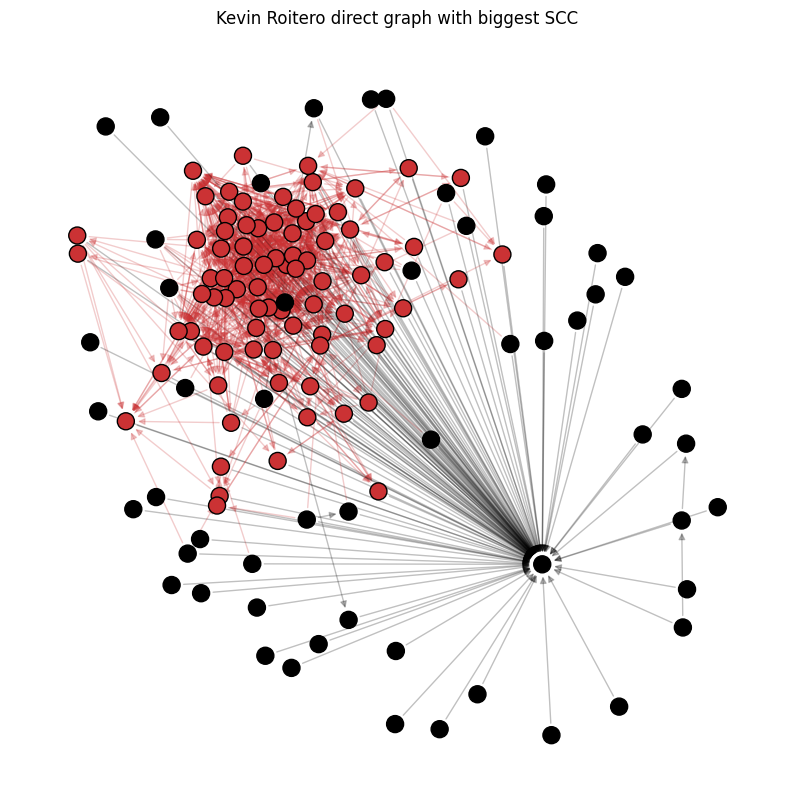

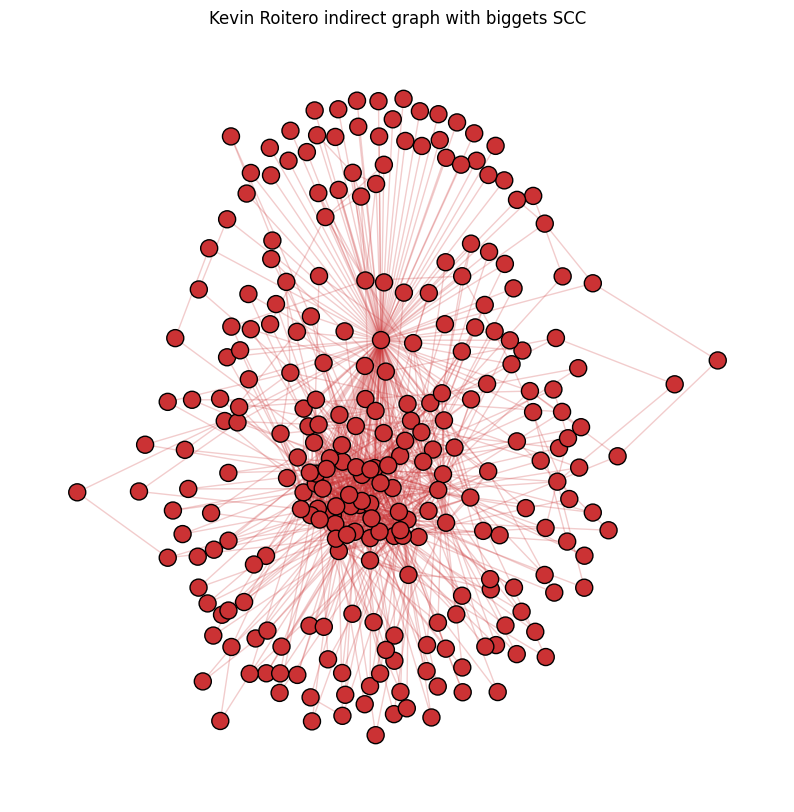

In [17]:
# SCC più grande del grafo diretto

# Elementi della SCC più grande
kevinroitero_direct_graph_largest_scc = max(networkx.strongly_connected_components(kevinroitero_direct_graph), key=len)

# Visualizzazione della SCC più grande del grafo diretto

# Creo i colori, labels dei nodi
c_nodes = []
labels = {}
for id, node in kevinroitero_direct_graph.nodes(data=True):
    if(id in kevinroitero_direct_graph_largest_scc):
        c_nodes.append(c_rosso)
    else:
        c_nodes.append(c_nero)
    labels[id] = node["username"]

# Creo i colori degli archi
c_edges = []
for edge in kevinroitero_direct_graph.edges:
    if(edge[1] in kevinroitero_direct_graph_largest_scc): # edge[1] = edge["to"]
        c_edges.append(f"{c_rosso}{c_alpha}")
    else:
        c_edges.append(f"{c_nero}{c_alpha}")

draw(kevinroitero_direct_graph, networkx.spring_layout(kevinroitero_direct_graph), c_nodes, c_edges, labels, False, 150, "Kevin Roitero direct graph with biggest SCC", f"{view_folder}/kevinroitero_direct_graph_scc.png")

# SCC più grande del grafo indiretto

# Per il grafo indiretto si trova ovviamente una singola SCC contenente tutti gli elementi del grafo
# Da definizione un grafo non orientato se è connesso sarà ovviamente fortemente connesso, quidni controlliamo che il nostro grafo indiretto sia connesso

# Elementi della SCC più grande
kevinroitero_indirect_graph_preferential_attachment_largest_scc = max(networkx.connected_components(kevinroitero_indirect_graph_preferential_attachment), key=len)

# Visualizzazione della SCC più grande del grafo indiretto

# Creo i colori, labels
c_nodes = []
labels = {}
for id, node in kevinroitero_indirect_graph_preferential_attachment.nodes(data=True):
    if(id in kevinroitero_indirect_graph_preferential_attachment_largest_scc):
        c_nodes.append(c_rosso)
    else:
        c_nodes.append(c_nero)
    if(id in range(len(kevinroitero_direct_graph.nodes), len(kevinroitero_direct_graph.nodes)*2)):
        node["username"] = f"attacamento preferenziale {id-len(kevinroitero_direct_graph.nodes)+1}"
    labels[id] = node["username"]

# Creo i colori degli archi
c_edges = []
for edge in kevinroitero_indirect_graph_preferential_attachment.edges:
    if(edge[1] in kevinroitero_indirect_graph_preferential_attachment_largest_scc or edge[0] in kevinroitero_indirect_graph_preferential_attachment_largest_scc): # edge[1] = edge["to"], edge[0] = edge["from"]
        c_edges.append(f"{c_rosso}{c_alpha}")
    else:
        c_edges.append(f"{c_nero}{c_alpha}")

draw(kevinroitero_indirect_graph_preferential_attachment, networkx.spring_layout(kevinroitero_indirect_graph_preferential_attachment), c_nodes, c_edges, labels, False, 150, "Kevin Roitero indirect graph with biggets SCC", f"{view_folder}/kevinroitero_indirect_graph_scc.png")


# 8.Misurare le seguenti distanze sui due grafi (usando le opportune funzioni di NetworkX):
1. Centro
2. Raggio
3. Distanza Media
4. Distanza Massima

In [18]:
!mkdir stats

mkdir: stats: File exists


In [19]:
#creo grafo scc

kevinroitero_direct_graph_largest_scc = max(networkx.strongly_connected_components(kevinroitero_direct_graph), key=len)

kevinroitero_direct_graph_largest_scc_graph = kevinroitero_direct_graph.subgraph(list(kevinroitero_direct_graph_largest_scc))

# Distanze per grafo diretto

kevinroitero_direct_graph_center = networkx.center(kevinroitero_direct_graph_largest_scc_graph)
kevinroitero_direct_graph_radius = networkx.radius(kevinroitero_direct_graph_largest_scc_graph)
kevinroitero_direct_graph_average = networkx.average_shortest_path_length(kevinroitero_direct_graph_largest_scc_graph)
kevinroitero_direct_graph_diameter = networkx.diameter(kevinroitero_direct_graph_largest_scc_graph)

# Creo un dataframe

kevinroitero_direct_graph_distances = {
    'values': [kevinroitero_direct_graph_center, kevinroitero_direct_graph_radius, kevinroitero_direct_graph_average, kevinroitero_direct_graph_diameter]
}

kevinroitero_direct_graph_distances_df = pd.DataFrame(kevinroitero_direct_graph_distances, index=['center', 'radius', 'average', 'diameter'])

# Salvo in csv

kevinroitero_direct_graph_distances_df.to_csv(f"{stats_folder}/kevinroitero_direct_graph_distances.csv", index=True)

print(kevinroitero_direct_graph_distances_df)


                                                     values
center    [28607182, 1546349170315120640, 15207332366782...
radius                                                    3
average                                            2.252848
diameter                                                  6


In [20]:
# Leggo il file csv

kevinroitero_direct_graph_distances_df = pd.read_csv(f"{stats_folder}/kevinroitero_direct_graph_distances.csv")


In [21]:
# Distanze per grafo indiretto

kevinroitero_indirect_graph_preferential_attachment_center = networkx.center(kevinroitero_indirect_graph_preferential_attachment)
kevinroitero_indirect_graph_preferential_attachment_radius = networkx.radius(kevinroitero_indirect_graph_preferential_attachment)
kevinroitero_indirect_graph_preferential_attachment_average = networkx.average_shortest_path_length(kevinroitero_indirect_graph_preferential_attachment)
kevinroitero_indirect_graph_preferential_attachment_diameter = networkx.diameter(kevinroitero_indirect_graph_preferential_attachment)

# Creo un dataframe

kevinroitero_indirect_graph_preferential_attachment_distances = {
    'values': [kevinroitero_indirect_graph_preferential_attachment_center, kevinroitero_indirect_graph_preferential_attachment_radius, kevinroitero_indirect_graph_preferential_attachment_average, kevinroitero_indirect_graph_preferential_attachment_diameter]
}

kevinroitero_indirect_graph_preferential_attachment_distances_df = pd.DataFrame(kevinroitero_indirect_graph_preferential_attachment_distances, index=['center', 'radius', 'average', 'diameter'])

# Salvo in csv

kevinroitero_indirect_graph_preferential_attachment_distances_df.to_csv(f"{stats_folder}/kevinroitero_indirect_graph_distances.csv", index=True)

print(kevinroitero_indirect_graph_preferential_attachment_distances_df)


                                                     values
center    [3036907250, 998681467696885761, 1176475874759...
radius                                                    3
average                                            2.545279
diameter                                                  5


In [22]:
# Leggo il file csv

kevinroitero_indirect_graph_preferential_attachment_distances_df = pd.read_csv(f"{stats_folder}/kevinroitero_indirect_graph_distances.csv")


# 9.Calcolare le seguenti misure di centralità sui due grafi:
1. Betweenness centrality
2. Closeness centrality
3. Degree centrality
4. In-degree centrality
5. Out-degree centrality
6. Page Rank
7. HITS

In [23]:
# Centralità su grafo diretto

kevinroitero_direct_graph_betweenness = networkx.betweenness_centrality(kevinroitero_direct_graph)
kevinroitero_direct_graph_closeness = networkx.closeness_centrality(kevinroitero_direct_graph)
kevinroitero_direct_graph_degree = networkx.degree_centrality(kevinroitero_direct_graph)
kevinroitero_direct_graph_in_degree = networkx.in_degree_centrality(kevinroitero_direct_graph)
kevinroitero_direct_graph_out_degree = networkx.out_degree_centrality(kevinroitero_direct_graph)

# Centralità ricorsive su grafo diretto

kevinroitero_direct_graph_page_rank = networkx.pagerank(kevinroitero_direct_graph)
kevinroitero_direct_graph_hits = networkx.hits(kevinroitero_direct_graph) #HITS restituisce una tupla di due dizionari, vanno divisi

# Creo un dataframe

kevinroitero_direct_graph_centrality = {
    "betweenness": list(kevinroitero_direct_graph_betweenness.values()),
    "closeness": list(kevinroitero_direct_graph_closeness.values()),
    "degree": list(kevinroitero_direct_graph_degree.values()),
    "in degree": list(kevinroitero_direct_graph_in_degree.values()),
    "out degree": list(kevinroitero_direct_graph_out_degree.values()),
    "page rank": list(kevinroitero_direct_graph_page_rank.values()),
    "hits hub": list(kevinroitero_direct_graph_hits[0].values()),
    "hits authority": list(kevinroitero_direct_graph_hits[1].values())
}

kevinroitero_direct_graph_centrality_df = pd.DataFrame(kevinroitero_direct_graph_centrality, index=list(kevinroitero_direct_graph_betweenness.keys()))

# Salvo in csv

kevinroitero_direct_graph_centrality_df.to_csv(f"{stats_folder}/kevinroitero_direct_graph_centrality.csv", index=True)

print(kevinroitero_direct_graph_centrality_df)


                     betweenness  closeness    degree  in degree  out degree  \
3036907250              0.000000   1.000000  1.000000   1.000000    0.000000   
2582519183              0.000000   0.243990  0.037594   0.015038    0.022556   
1558731210570010624     0.000000   0.000000  0.007519   0.000000    0.007519   
998681467696885761      0.004835   0.346466  0.353383   0.142857    0.210526   
1176475874759270400     0.000000   0.000000  0.030075   0.000000    0.030075   
...                          ...        ...       ...        ...         ...   
569382995               0.000000   0.000000  0.030075   0.000000    0.030075   
51023058                0.000467   0.248363  0.045113   0.030075    0.015038   
2827812417              0.000000   0.000000  0.015038   0.000000    0.015038   
1556357336              0.046755   0.251062  0.112782   0.052632    0.060150   
3053756746              0.000000   0.000000  0.007519   0.000000    0.007519   

                     page rank  hits hu

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/networkx/algorithms/link_analysis/hits_alg.py:78: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G, nodelist=list(G), dtype=float)


In [24]:
# Migliori per ogni grandezza di centralità (extra)

kevinroitero_direct_graph_betweenness_best = kevinroitero_direct_graph_centrality_df.sort_values("betweenness", ascending = False).iloc[0]
kevinroitero_direct_graph_closeness_best = kevinroitero_direct_graph_centrality_df.sort_values("closeness", ascending = False).iloc[0]
kevinroitero_direct_graph_degree_best = kevinroitero_direct_graph_centrality_df.sort_values("degree", ascending = False).iloc[0]
kevinroitero_direct_graph_in_degree_best = kevinroitero_direct_graph_centrality_df.sort_values("in degree", ascending = False).iloc[0]
kevinroitero_direct_graph_out_degree_best = kevinroitero_direct_graph_centrality_df.sort_values("out degree", ascending = False).iloc[0]
kevinroitero_direct_graph_centrality_page_rank_best = kevinroitero_direct_graph_centrality_df.sort_values("page rank", ascending=False).iloc[0]
kevinroitero_direct_graph_centrality_hits_hub_best = kevinroitero_direct_graph_centrality_df.sort_values("hits hub", ascending = False).iloc[0]
kevinroitero_direct_graph_centrality_hits_authority_best = kevinroitero_direct_graph_centrality_df.sort_values("hits authority", ascending = False).iloc[0]

print(f"Betweennes:\n{kevinroitero_direct_graph_betweenness_best}\n")
print(f"Closeness:\n{kevinroitero_direct_graph_closeness_best}\n")
print(f"Degree:\n{kevinroitero_direct_graph_degree_best}\n")
print(f"In degree:\n{kevinroitero_direct_graph_in_degree_best}\n")
print(f"Out degree:\n{kevinroitero_direct_graph_out_degree_best}\n")
print(f"Page rank:\n{kevinroitero_direct_graph_centrality_page_rank_best}\n")
print(f"HITS hub:\n{kevinroitero_direct_graph_centrality_hits_hub_best}\n")
print(f"HITS authority:\n{kevinroitero_direct_graph_centrality_hits_authority_best}\n")


Betweennes:
betweenness       0.064556
closeness         0.468198
degree            0.578947
in degree         0.360902
out degree        0.218045
page rank         0.029489
hits hub          0.018983
hits authority    0.037680
Name: 132646210, dtype: float64

Closeness:
betweenness       0.000000
closeness         1.000000
degree            1.000000
in degree         1.000000
out degree        0.000000
page rank         0.124931
hits hub         -0.000000
hits authority    0.055508
Name: 3036907250, dtype: float64

Degree:
betweenness       0.000000
closeness         1.000000
degree            1.000000
in degree         1.000000
out degree        0.000000
page rank         0.124931
hits hub         -0.000000
hits authority    0.055508
Name: 3036907250, dtype: float64

In degree:
betweenness       0.000000
closeness         1.000000
degree            1.000000
in degree         1.000000
out degree        0.000000
page rank         0.124931
hits hub         -0.000000
hits authority    0.

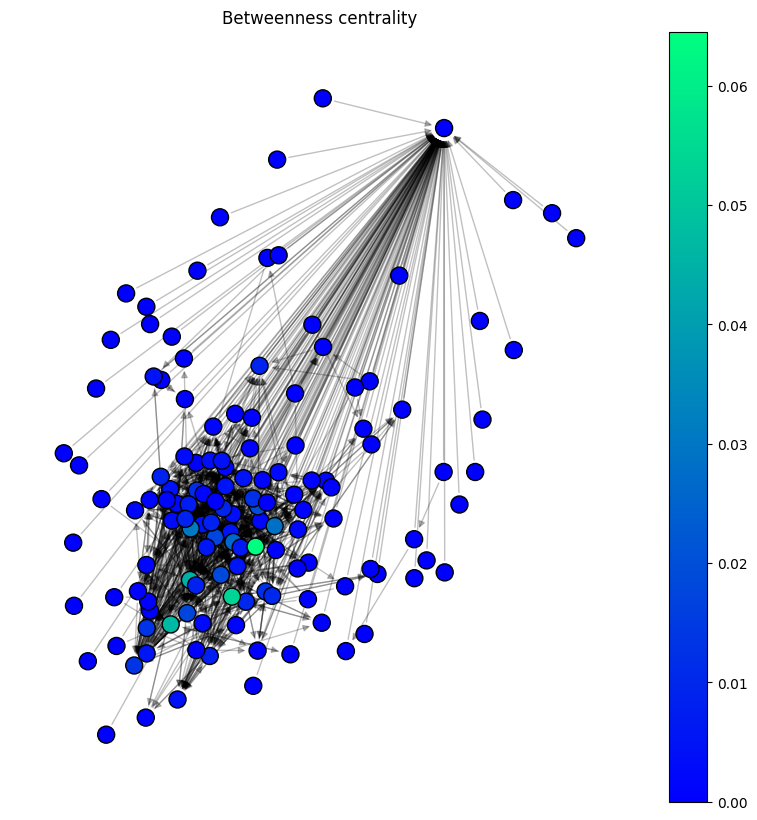

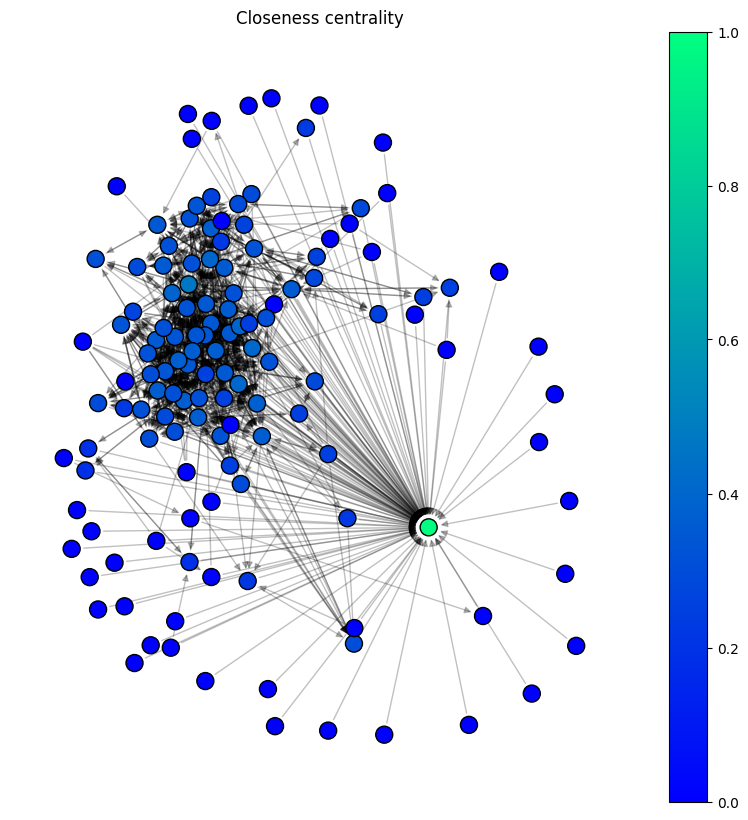

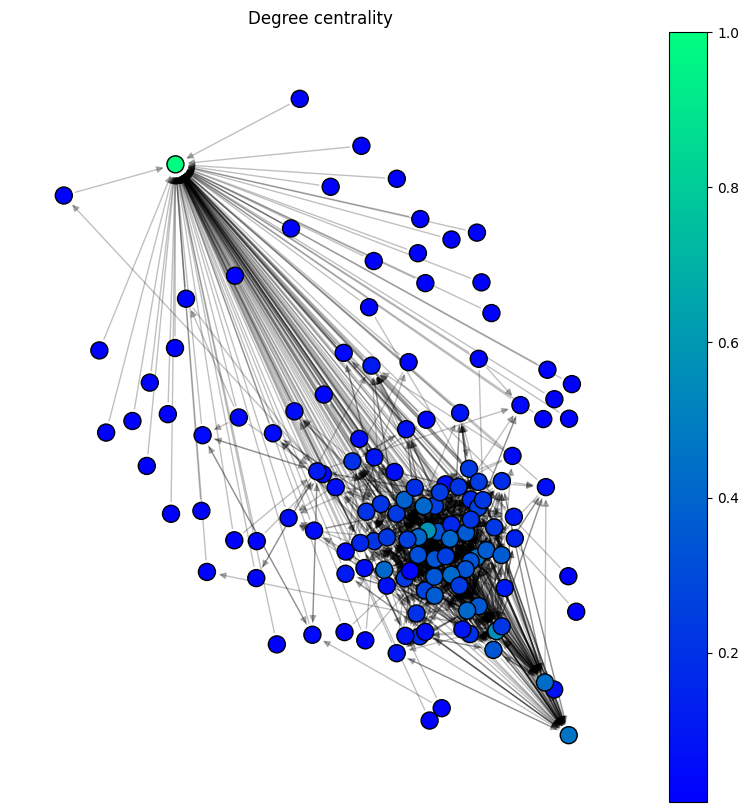

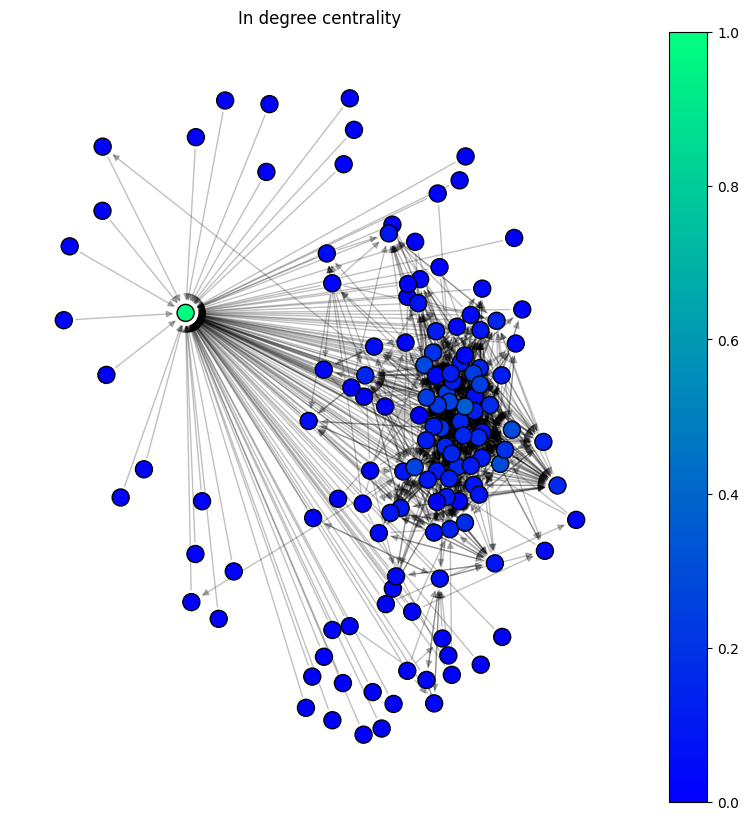

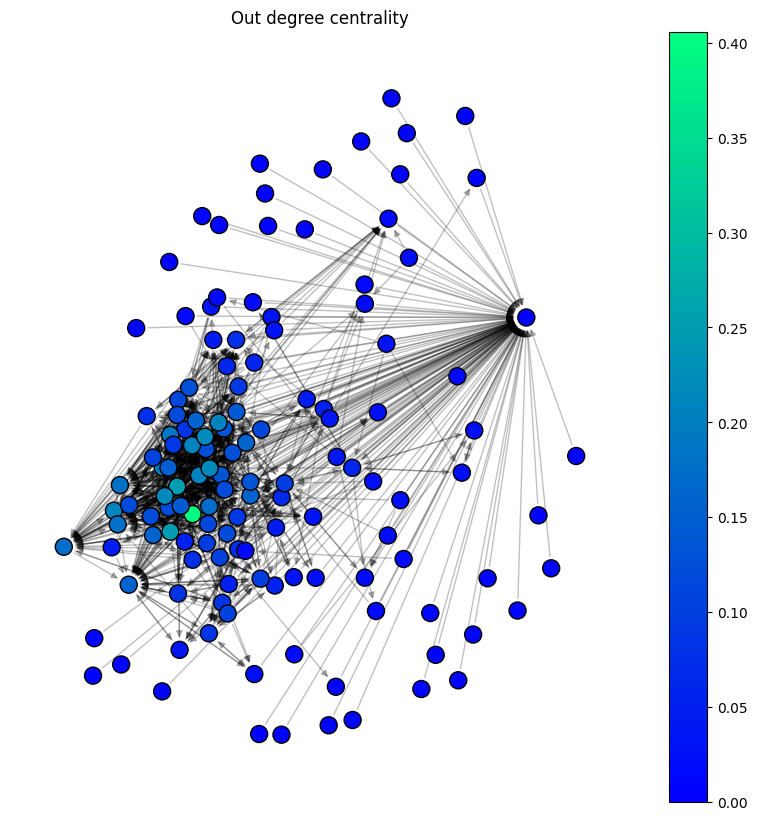

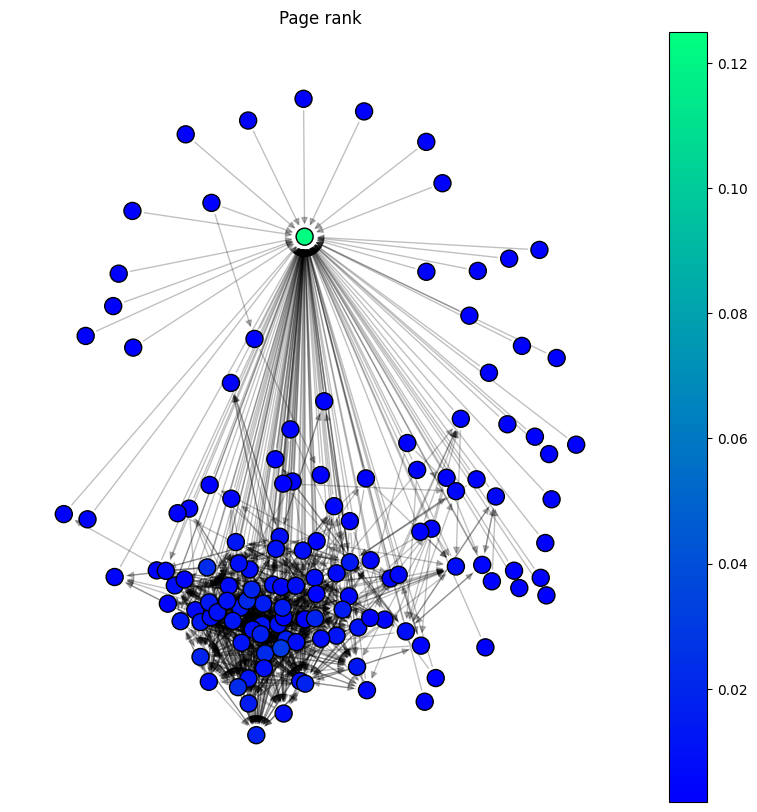

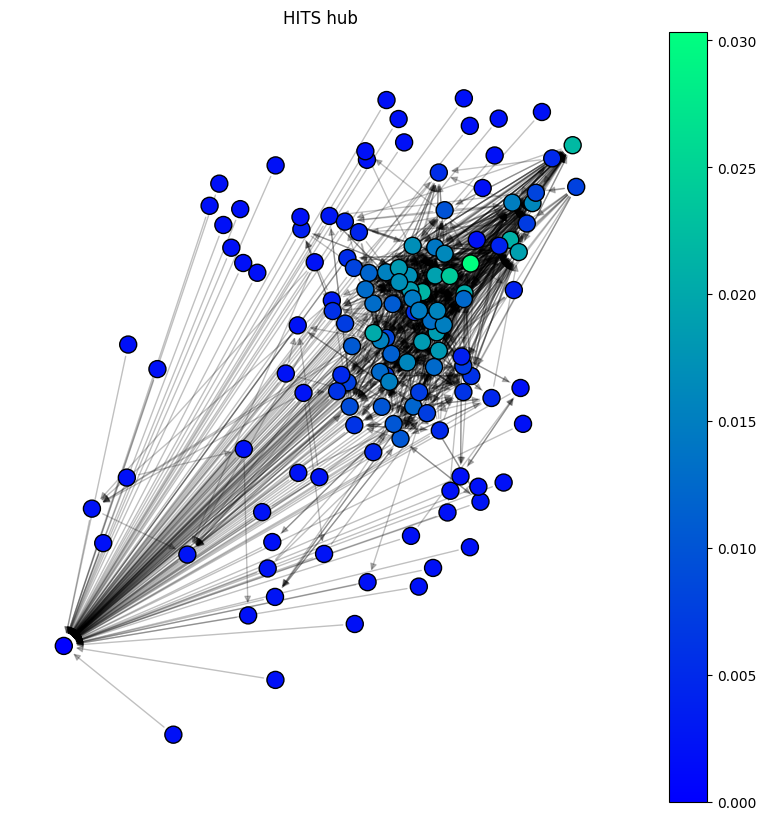

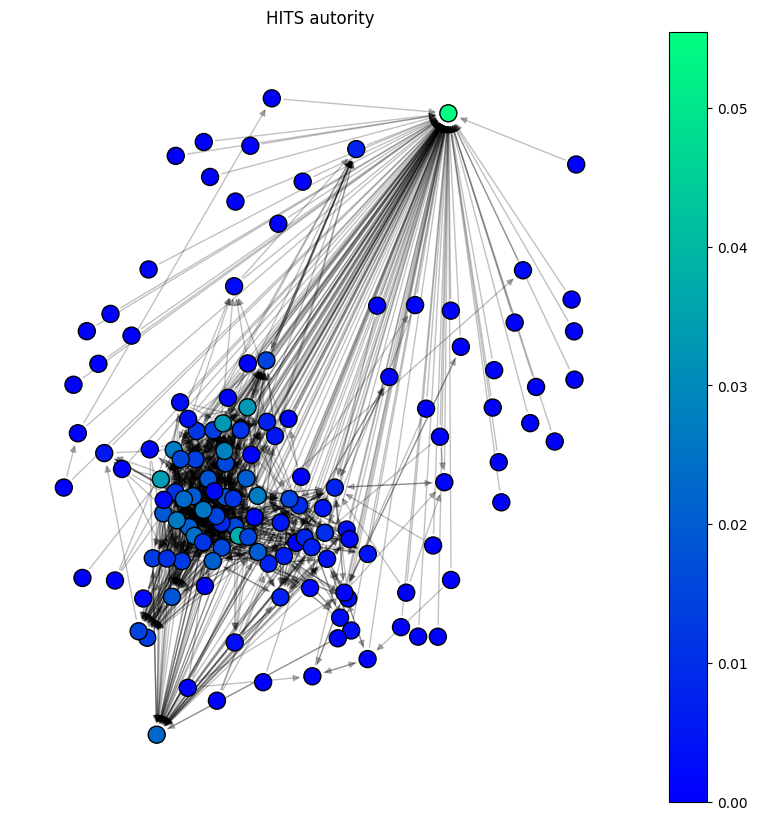

In [25]:
# Visualizzazione delle centralità del grafo diretto (extra)

draw_measure(kevinroitero_direct_graph, networkx.spring_layout(kevinroitero_direct_graph), False, kevinroitero_direct_graph_betweenness, 'Betweenness centrality', f"{stats_folder}/kevinroitero_direct_graph_betweenness.png")
draw_measure(kevinroitero_direct_graph, networkx.spring_layout(kevinroitero_direct_graph), False, kevinroitero_direct_graph_closeness, 'Closeness centrality', f"{stats_folder}/kevinroitero_direct_graph_closeness.png")
draw_measure(kevinroitero_direct_graph, networkx.spring_layout(kevinroitero_direct_graph), False, kevinroitero_direct_graph_degree, 'Degree centrality', f"{stats_folder}/kevinroitero_direct_graph_degree.png")
draw_measure(kevinroitero_direct_graph, networkx.spring_layout(kevinroitero_direct_graph), False, kevinroitero_direct_graph_in_degree, 'In degree centrality', f"{stats_folder}/kevinroitero_direct_graph_in_degree.png")
draw_measure(kevinroitero_direct_graph, networkx.spring_layout(kevinroitero_direct_graph), False, kevinroitero_direct_graph_out_degree, 'Out degree centrality', f"{stats_folder}/kevinroitero_direct_graph_out_degree.png")
draw_measure(kevinroitero_direct_graph, networkx.spring_layout(kevinroitero_direct_graph), False, kevinroitero_direct_graph_page_rank, 'Page rank', f"{stats_folder}/kevinroitero_direct_graph_page_rank.png")
draw_measure(kevinroitero_direct_graph, networkx.spring_layout(kevinroitero_direct_graph), False, kevinroitero_direct_graph_hits[0], 'HITS hub', f"{stats_folder}/kevinroitero_direct_graph_hits_hub.png")
draw_measure(kevinroitero_direct_graph, networkx.spring_layout(kevinroitero_direct_graph), False, kevinroitero_direct_graph_hits[1], 'HITS autority', f"{stats_folder}/kevinroitero_direct_graph_hits_autority.png")


In [26]:
# Leggo il file csv

kevinroitero_direct_graph_centrality_df = pd.read_csv(f"{stats_folder}/kevinroitero_direct_graph_centrality.csv")


In [27]:
# Centralità su grafo indiretto

kevinroitero_indirect_graph_preferential_attachment_betweenness = networkx.betweenness_centrality(kevinroitero_indirect_graph_preferential_attachment)
kevinroitero_indirect_graph_preferential_attachment_closeness = networkx.closeness_centrality(kevinroitero_indirect_graph_preferential_attachment)
kevinroitero_indirect_graph_preferential_attachment_degree = networkx.degree_centrality(kevinroitero_indirect_graph_preferential_attachment)

# Centralità ricorsive su grafo indiretto

kevinroitero_indirect_graph_preferential_attachment_page_rank = networkx.pagerank(kevinroitero_indirect_graph_preferential_attachment)
kevinroitero_indirect_graph_preferential_attachment_hits = networkx.hits(kevinroitero_indirect_graph_preferential_attachment) #HITS restituisce una tupla di due dizionari, vanno divisi


# Creo un dataframe

kevinroitero_indirect_graph_preferential_attachment_centrality = {
    "betweenness": list(kevinroitero_indirect_graph_preferential_attachment_betweenness.values()),
    "closeness": list(kevinroitero_indirect_graph_preferential_attachment_closeness.values()),
    "degree": list(kevinroitero_indirect_graph_preferential_attachment_degree.values()),
    "page rank": list(kevinroitero_indirect_graph_preferential_attachment_page_rank.values()),
    "hits hub": list(kevinroitero_indirect_graph_preferential_attachment_hits[0].values()),
    "hits authority": list(kevinroitero_indirect_graph_preferential_attachment_hits[1].values())
}

kevinroitero_indirect_graph_preferential_attachment_centrality_df = pd.DataFrame(kevinroitero_indirect_graph_preferential_attachment_centrality, index=list(kevinroitero_indirect_graph_preferential_attachment_betweenness.keys()))

# Salvo in csv

kevinroitero_indirect_graph_preferential_attachment_centrality_df.to_csv(f"{stats_folder}/kevinroitero_indirect_graph_centrality.csv", index=True)

print(kevinroitero_indirect_graph_preferential_attachment_centrality_df)


                     betweenness  closeness    degree  page rank  hits hub  \
3036907250              0.501207   0.695312  0.565543   0.073774  0.029780   
2582519183              0.003435   0.418495  0.018727   0.002839  0.001484   
1558731210570010624     0.000000   0.410769  0.003745   0.000975  0.001010   
998681467696885761      0.011261   0.497207  0.112360   0.009986  0.014859   
1176475874759270400     0.000000   0.423810  0.014981   0.001859  0.002835   
...                          ...        ...       ...        ...       ...   
263                     0.000000   0.352708  0.007491   0.001178  0.000868   
264                     0.000000   0.369295  0.007491   0.001173  0.001190   
265                     0.000015   0.354111  0.007491   0.001168  0.000932   
266                     0.000000   0.364256  0.007491   0.001181  0.001007   
267                     0.000014   0.315230  0.007491   0.001581  0.000251   

                     hits authority  
3036907250               

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/networkx/algorithms/link_analysis/hits_alg.py:78: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G, nodelist=list(G), dtype=float)


In [28]:
# Migliori per ogni grandezza di centralità (extra)

kevinroitero_indirect_graph_preferential_attachment_betweenness_best = kevinroitero_indirect_graph_preferential_attachment_centrality_df.sort_values("betweenness", ascending = False).iloc[0]
kevinroitero_indirect_graph_preferential_attachment_closeness_best = kevinroitero_indirect_graph_preferential_attachment_centrality_df.sort_values("closeness", ascending = False).iloc[0]
kevinroitero_indirect_graph_preferential_attachment_degree_best = kevinroitero_indirect_graph_preferential_attachment_centrality_df.sort_values("degree", ascending = False).iloc[0]
kevinroitero_indirect_graph_preferential_attachment_centrality_page_rank_best = kevinroitero_indirect_graph_preferential_attachment_centrality_df.sort_values("page rank", ascending=False).iloc[0]
kevinroitero_indirect_graph_preferential_attachment_centrality_hits_hub_best = kevinroitero_indirect_graph_preferential_attachment_centrality_df.sort_values("hits hub", ascending = False).iloc[0]
kevinroitero_indirect_graph_preferential_attachment_centrality_hits_authority_best = kevinroitero_indirect_graph_preferential_attachment_centrality_df.sort_values("hits authority",ascending = False).iloc[0]

print(f"Betweennes Centrality:\n{kevinroitero_indirect_graph_preferential_attachment_betweenness_best}\n")
print(f"Closeness Centrality:\n{kevinroitero_indirect_graph_preferential_attachment_closeness_best}\n")
print(f"Degree Centrality:\n{kevinroitero_indirect_graph_preferential_attachment_degree_best}\n")
print(f"Page rank:\n{kevinroitero_indirect_graph_preferential_attachment_centrality_page_rank_best}\n")
print(f"HITS hub:\n{kevinroitero_indirect_graph_preferential_attachment_centrality_hits_hub_best}\n")
print(f"HITS authority:\n{kevinroitero_indirect_graph_preferential_attachment_centrality_hits_authority_best}\n")


Betweennes Centrality:
betweenness       0.501207
closeness         0.695312
degree            0.565543
page rank         0.073774
hits hub          0.029780
hits authority    0.029780
Name: 3036907250, dtype: float64

Closeness Centrality:
betweenness       0.501207
closeness         0.695312
degree            0.565543
page rank         0.073774
hits hub          0.029780
hits authority    0.029780
Name: 3036907250, dtype: float64

Degree Centrality:
betweenness       0.501207
closeness         0.695312
degree            0.565543
page rank         0.073774
hits hub          0.029780
hits authority    0.029780
Name: 3036907250, dtype: float64

Page rank:
betweenness       0.501207
closeness         0.695312
degree            0.565543
page rank         0.073774
hits hub          0.029780
hits authority    0.029780
Name: 3036907250, dtype: float64

HITS hub:
betweenness       0.501207
closeness         0.695312
degree            0.565543
page rank         0.073774
hits hub          0.029

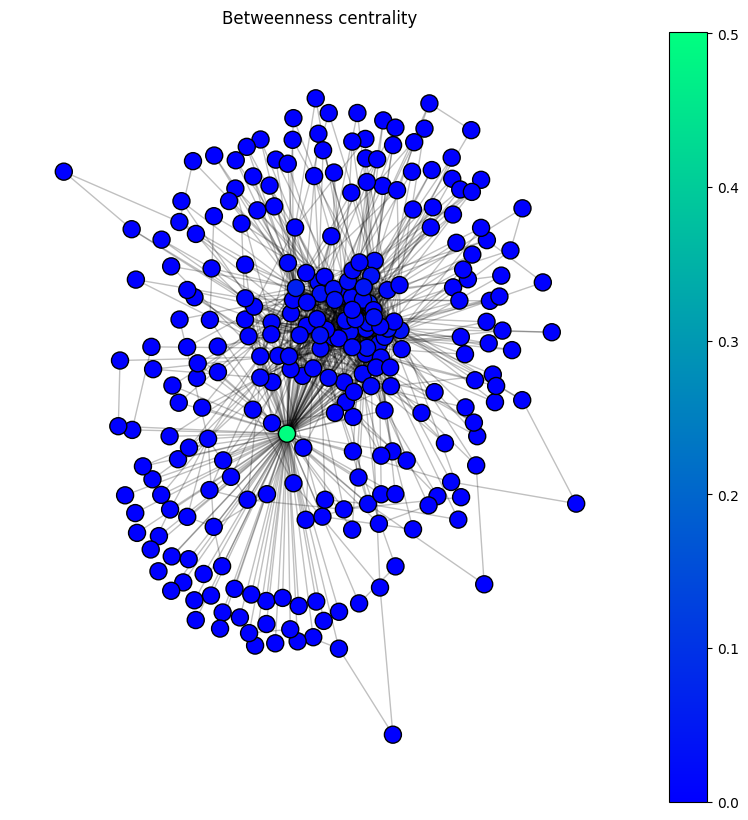

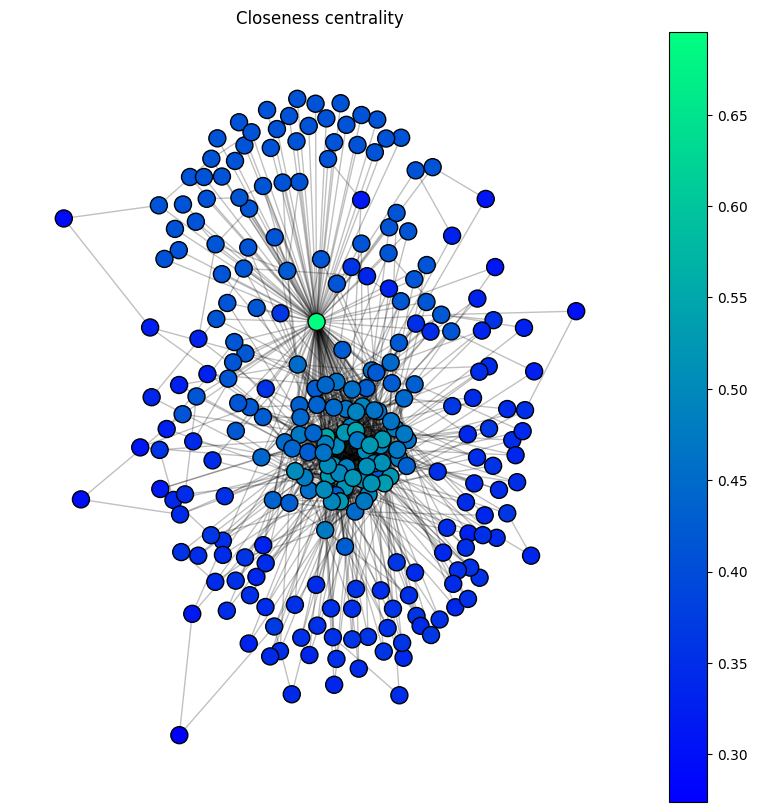

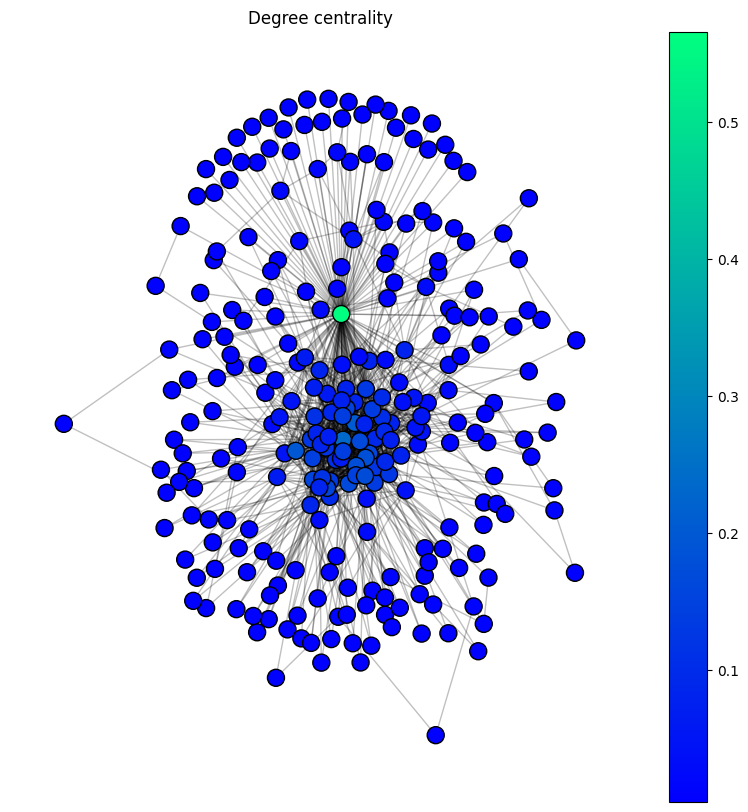

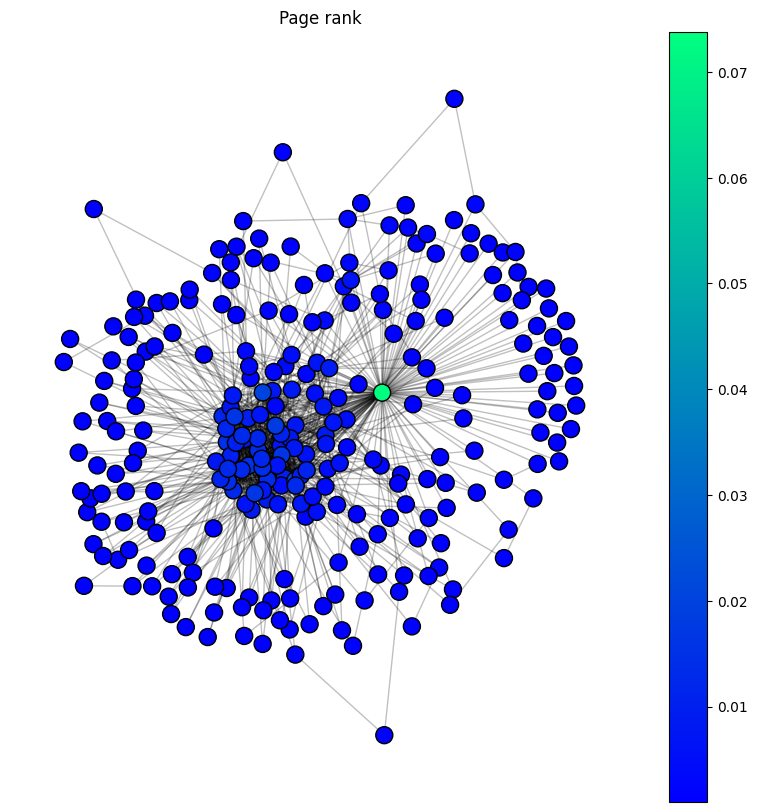

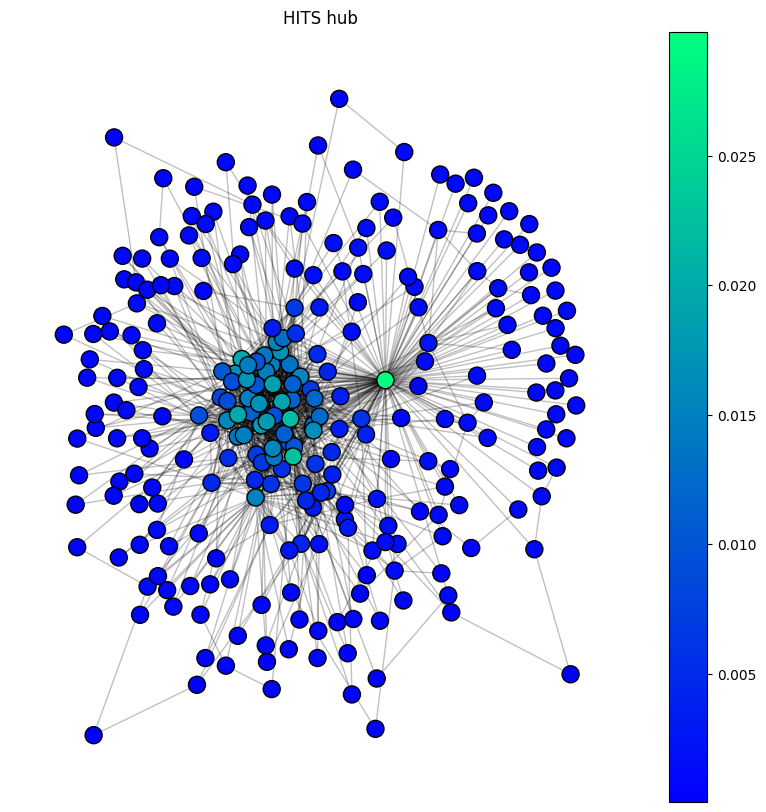

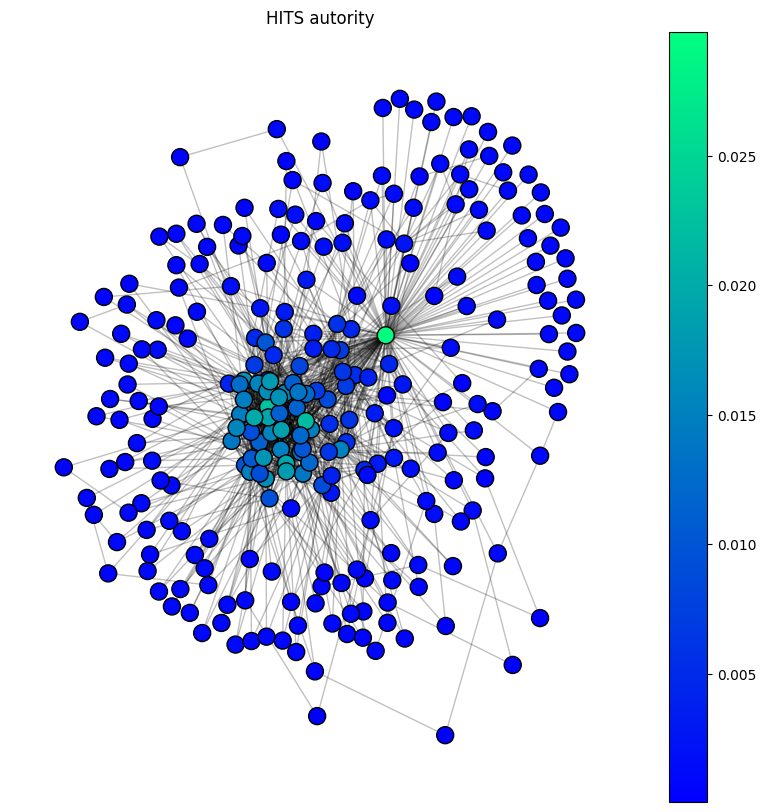

In [29]:
# Visualizzazione delle centralità del grafo indiretto (extra)

draw_measure(kevinroitero_indirect_graph_preferential_attachment, networkx.spring_layout(kevinroitero_indirect_graph_preferential_attachment), False, kevinroitero_indirect_graph_preferential_attachment_betweenness, 'Betweenness centrality', f"{stats_folder}/kevinroitero_indirect_graph_betweenness.png")
draw_measure(kevinroitero_indirect_graph_preferential_attachment, networkx.spring_layout(kevinroitero_indirect_graph_preferential_attachment), False, kevinroitero_indirect_graph_preferential_attachment_closeness, 'Closeness centrality', f"{stats_folder}/kevinroitero_indirect_graph_closeness.png")
draw_measure(kevinroitero_indirect_graph_preferential_attachment, networkx.spring_layout(kevinroitero_indirect_graph_preferential_attachment), False, kevinroitero_indirect_graph_preferential_attachment_degree, 'Degree centrality', f"{stats_folder}/kevinroitero_indirect_graph_degree.png")
draw_measure(kevinroitero_indirect_graph_preferential_attachment, networkx.spring_layout(kevinroitero_indirect_graph_preferential_attachment), False, kevinroitero_indirect_graph_preferential_attachment_page_rank, 'Page rank', f"{stats_folder}/kevinroitero_indirect_graph_page_rank.png")
draw_measure(kevinroitero_indirect_graph_preferential_attachment, networkx.spring_layout(kevinroitero_indirect_graph_preferential_attachment), False, kevinroitero_indirect_graph_preferential_attachment_hits[0], 'HITS hub', f"{stats_folder}/kevinroitero_indirect_graph_hits_hub.png")
draw_measure(kevinroitero_indirect_graph_preferential_attachment, networkx.spring_layout(kevinroitero_indirect_graph_preferential_attachment), False, kevinroitero_indirect_graph_preferential_attachment_hits[1], 'HITS autority', f"{stats_folder}/kevinroitero_indirect_graph_hits_autority.png")


In [30]:
# Leggo il file csv

kevinroitero_indirect_graph_preferential_attachment_centrality_df = pd.read_csv(f"{stats_folder}/kevinroitero_indirect_graph_centrality.csv")


# 10.Calcolare i seguenti coefficienti per stimare la “small-world-ness” dei due grafi (usando le opportune funzioni di NetworkX):
1. Coefficiente omega
2. Coefficiente sigma

In [31]:
# Calcolo coefficienti del grafo indiretto

kevinroitero_indirect_graph_preferential_attachment_omega = networkx.omega(kevinroitero_indirect_graph_preferential_attachment)
kevinroitero_indirect_graph_preferential_attachment_sigma = networkx.sigma(kevinroitero_indirect_graph_preferential_attachment)

# Creo un dataframe

kevinroitero_indirect_graph_preferential_attachment_small_world = {
    'values': [kevinroitero_indirect_graph_preferential_attachment_omega, kevinroitero_indirect_graph_preferential_attachment_sigma]
}

kevinroitero_indirect_graph_preferential_attachment_small_world_df = pd.DataFrame(kevinroitero_indirect_graph_preferential_attachment_small_world, index=['omega', 'sigma'])

# Salvo in csv

kevinroitero_indirect_graph_preferential_attachment_small_world_df.to_csv(f"{stats_folder}/kevinroitero_indirect_graph_small_world.csv", index=True)

print(kevinroitero_indirect_graph_preferential_attachment_small_world_df)

#print(f"Omega:\n{Omega}")
#0.0664398099615815

#print(f"Sigma:\n{Sigma}")
#1.2847516562164538

         values
omega  0.181947
sigma  1.327558


In [32]:
# Leggo il file csv

kevinroitero_indirect_graph_preferential_attachment_small_world_df = pd.read_csv(f"{stats_folder}/kevinroitero_indirect_graph_small_world.csv")


In [33]:
# Calcolo coefficienti del grafo "diretto" (extra)

kevinroitero_indirect_graph_omega = networkx.omega(kevinroitero_indirect_graph)
kevinroitero_indirect_graph_sigma = networkx.sigma(kevinroitero_indirect_graph)

# Creo un dataframe

kevinroitero_indirect_graph_small_world = {
    'values': [kevinroitero_indirect_graph_omega, kevinroitero_indirect_graph_sigma]
}

kevinroitero_indirect_graph_small_world_df = pd.DataFrame(kevinroitero_indirect_graph_small_world, index=['omega', 'sigma'])

# Salvo in csv

kevinroitero_indirect_graph_small_world_df.to_csv(f"{stats_folder}/kevinroitero_direct_graph_small_world.csv", index=True)

print(kevinroitero_indirect_graph_small_world_df)


         values
omega  0.106616
sigma  1.220551


In [34]:
# Leggo il file csv

kevinroitero_indirect_graph_small_world_df = pd.read_csv(f"{stats_folder}/kevinroitero_direct_graph_small_world.csv")
